<a href="https://colab.research.google.com/github/carlacodes/atchekegroup1lunarlanding/blob/sherry/lunar_lander_group1_atcheke.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Performance Analysis of DQN Algorithm on the Lunar Lander task

**By Neuromatch Academy**

__Content creators:__ Raghuram Bharadwaj Diddigi, Geraud Nangue Tasse, Yamil Vidal, Sanjukta Krishnagopal, Sara Rajaee

__Content editors:__ Spiros Chavlis

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Objective

In this project, the objective is to analyze the performance of the Deep Q-Learning algorithm on an exciting task- Lunar Lander. Before we describe the task, let us focus on two keywords here - analysis and performance. What exactly do we mean by these keywords in the context of Reinforcement Learning (RL)?

---
# Setup

In [1]:
# @title Install dependencies
!sudo apt-get update > /dev/null 2>&1
!sudo apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install rarfile --quiet
!pip install stable-baselines3[extra] ale-py==0.7.4 --quiet
!pip install box2d-py --quiet
!pip install gym pyvirtualdisplay --quiet

     |████████████████████████████████| 177 kB 5.2 MB/s 
     |████████████████████████████████| 1.6 MB 56.5 MB/s 
     |████████████████████████████████| 1.5 MB 54.6 MB/s 
     |████████████████████████████████| 1.1 MB 73.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 448 kB 5.1 MB/s 


In [2]:
# Imports
import io
import os
import glob
import torch
import base64
import stable_baselines3

import numpy as np
import matplotlib.pyplot as plt

from stable_baselines3 import DQN
from stable_baselines3.common.results_plotter import ts2xy, load_results
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.env_util import make_atari_env

import gym
from gym import spaces
from gym.wrappers import Monitor,RecordVideo

In [ ]:
print(gym.__version__)

0.21.0


In [3]:
# @title Plotting/Video functions
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")


def wrap_env(env):
  env = Monitor(env, './video', force=True)
  # env = RecordVideo(env, './video')
  return env

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
drive_path = "/content/gdrive/My Drive/LunarLanding/models/"

Mounted at /content/gdrive


---
# Introduction

In a standard RL setting, an agent learns optimal behavior from an environment through a feedback mechanism to maximize a given objective. Many algorithms have been proposed in the RL literature that an agent can apply to learn the optimal behavior. One such popular algorithm is the Deep Q-Network (DQN). This algorithm makes use of deep neural networks to compute optimal actions. In this project, your goal is to understand the effect of the number of neural network layers on the algorithm's performance. The performance of the algorithm can be evaluated through two metrics - Speed and Stability. 

**Speed:** How fast the algorithm reaches the maximum possible reward. 

**Stability** In some applications (especially when online learning is involved), along with speed, stability of the algorithm, i.e., minimal fluctuations in performance, is equally important. 

In this project, you should investigate the following question:

**What is the impact of number of neural network layers on speed and stability of the algorithm?**

You do not have to write the DQN code from scratch. We have provided a basic implementation of the DQN algorithm. You only have to tune the hyperparameters (neural network size, learning rate, etc), observe the performance, and analyze. More details on this are provided below. 

Now, let us discuss the RL task we have chosen, i.e., Lunar Lander. This task consists of the lander and a landing pad marked by two flags. The episode starts with the lander moving downwards due to gravity. The objective is to land safely using different engines available on the lander with zero speed on the landing pad as quickly and fuel efficient as possible. Reward for moving from the top of the screen and landing on landing pad with zero speed is between 100 to 140 points. Each leg ground contact yields a reward of 10 points. Firing main engine leads to a reward of -0.3 points in each frame. Firing the side engine leads to a reward of -0.03 points in each frame. An additional reward of -100 or +100 points is received if the lander crashes or comes to rest respectively which also leads to end of the episode. 

The input state of the Lunar Lander consists of following components:

  1. Horizontal Position
  2. Vertical Position
  3. Horizontal Velocity
  4. Vertical Velocity
  5. Angle
  6. Angular Velocity
  7. Left Leg Contact
  8. Right Leg Contact

The actions of the agents are:
  1. Do Nothing
  2. Fire Main Engine
  3. Fire Left Engine
  4. Fire Right Engine


<img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/projects/static/lunar_lander.png">

## Tuning hyperparameters

ref: 

1.   template https://github.com/AI4Finance-Foundation/FinRL/blob/master/tutorials/4-Optimization/FinRL_HyperparameterTuning_using_Optuna_basic.ipynb

2.   tutorial (combined with template): https://medium.com/analytics-vidhya/hyperparameter-tuning-using-optuna-for-finrl-8a49506d2741

3.  set parameter function: https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/utils/hyperparams_opt.py

4.   callback function: https://github.com/DLR-RM/rl-baselines3-zoo/blob/master/utils/callbacks.py#L10





In [ ]:
!pip3 install optuna --quiet

In [ ]:
import optuna

from IPython.display import clear_output
import sys

### define search space

In [ ]:
# using stable baseline zoo parameter as ref
def sample_dqn_params(trial: optuna.Trial):
    """
    Sampler for DQN hyperparams.
    :param trial:
    :return:
    """
    learning_rate = trial.suggest_discrete_uniform('lr', 6.3e-4, 6.5e-4, 0.1e-4)

    # net_arch = trial.suggest_categorical("net_arch", ["two", "three"]) #, "two_big"
    # net_arch = {"two": [64, 64], "three": [64, 64, 64]}[net_arch] #, "two_big": [256, 256]

    hyperparams = {
        "learning_rate": learning_rate,#
        "policy_kwargs": dict(activation_fn=torch.nn.ReLU, net_arch=[64, 64]),
        "batch_size": 128,  #for simplicity, we are not doing batch update.
        "buffer_size": 50000, #size of experience of replay buffer. Set to 1 as batch update is not done
        "learning_starts": 0, #learning starts immediately!
        "gamma": 0.99, #discount facto. range is between 0 and 1.
        "tau": 1,  #the soft update coefficient for updating the target network
        "target_update_interval": 250, #update the target network immediately.
        "train_freq": (4,"step"), #train the network at every step.
        "max_grad_norm": 10, #the maximum value for the gradient clipping
        "exploration_initial_eps": 1, #initial value of random action probability
        "exploration_fraction": 0.12, #fraction of entire training period over which the exploration rate is reduced
        "gradient_steps": -1, #number of gradient steps
        "seed": 1, #seed for the pseudo random generators
        "verbose": 0
    }
    return hyperparams

### define callback

In [ ]:
class LoggingCallback:
    def __init__(self,threshold,trial_number,patience):
      '''
      threshold: int tolerance for increase in reward
      trial_number: int Prune after minimum number of trials
      patience: int patience for the threshold
      '''
      self.threshold = threshold
      self.trial_number  = trial_number
      self.patience = patience
      self.cb_list = [] #Trials list for which threshold is reached
    def __call__(self,study:optuna.study, frozen_trial:optuna.Trial):
      #Setting the best value in the current trial
      study.set_user_attr("previous_best_value", study.best_value)
      
      #Checking if the minimum number of trials have pass
      if frozen_trial.number >self.trial_number:
          previous_best_value = study.user_attrs.get("previous_best_value",None)
          #Checking if the previous and current objective values have the same sign
          if previous_best_value * study.best_value >=0:
              #Checking for the threshold condition
              if abs(previous_best_value-study.best_value) < self.threshold: 
                  self.cb_list.append(frozen_trial.number)
                  #If threshold is achieved for the patience amount of time
                  if len(self.cb_list)>self.patience:
                      print('The study stops now...')
                      print('With number',frozen_trial.number ,'and value ',frozen_trial.value)
                      print('The previous and current best values are {} and {} respectively'
                              .format(previous_best_value, study.best_value))
                      study.stop()

### [discarded] define template objective 

In [ ]:
log_dir = drive_path #"models"

def objective(trial:optuna.Trial):

  model_log_dir = log_dir+'dqn_{}'.format(trial.number)+'/'
  os.makedirs(model_log_dir,exist_ok=True) 
  # Create environment
  env = gym.make('LunarLander-v2')
  env = stable_baselines3.common.monitor.Monitor(env, filename= model_log_dir)

  #Trial will suggest a set of hyperparamters from the specified range
  hyperparameters = sample_dqn_params(trial)
  model_dqn = DQN("MlpPolicy", env, **hyperparameters) #Set verbose to 1 to observe training logs. We encourage you to set the verbose to 1.

  # define learning steps
  trained_dqn = model_dqn.learn(total_timesteps=1000, log_interval=10)#100000 , callback=callback
  # save model
  trained_dqn.save(model_log_dir +'dqn_{}.zip'.format(trial.number)) 

  x, y = ts2xy(load_results(model_log_dir), 'timesteps') # timesteps
  # clear_output(wait=True)
  #For the given hyperparamters, determine reward
  reward = sum(y)
  return reward

#Create a study object and specify the direction as 'maximize'
#As you want to maximize reward
#Pruner stops not promising iterations
#Use a pruner, else you will get error related to divergence of model
#You can also use Multivariate samplere
#sampler = optuna.samplers.TPESampler(multivarite=True,seed=42)
sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(study_name="dqn_study",direction='maximize',
                            sampler = sampler, pruner=optuna.pruners.HyperbandPruner())

logging_callback = LoggingCallback(threshold=10, patience=30, trial_number=5)
#You can increase the n_trials for a better search space scanning
study.optimize(objective, n_trials=2, catch=(ValueError,),callbacks=[logging_callback])

[I 2022-07-26 21:38:49,875] A new study created in memory with name: dqn_study
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning: The distribution is specified by [0.001, 0.01] and q=0.005, but the range is not divisible by `q`. It will be replaced by [0.001, 0.006].
  low=low, old_high=old_high, high=high, step=q
[I 2022-07-26 21:38:54,141] Trial 0 finished with value: -2644.398608 and parameters: {'lr': 0.001}. Best is trial 0 with value: -2644.398608.
/usr/local/lib/python3.7/dist-packages/optuna/distributions.py:548: UserWarning: The distribution is specified by [0.001, 0.01] and q=0.005, but the range is not divisible by `q`. It will be replaced by [0.001, 0.006].
  low=low, old_high=old_high, high=high, step=q
[I 2022-07-26 21:38:58,410] Trial 1 finished with value: -2592.8647579999997 and parameters: {'lr': 0.006}. Best is trial 1 with value: -2592.8647579999997.


### [discarded] get the best model

In [ ]:
#Get the best hyperparamters
print('Hyperparameters after tuning',study.best_params)

Hyperparameters after tuning {'lr': 0.006}


In [ ]:
study.best_trial

FrozenTrial(number=1, values=[-2592.8647579999997], datetime_start=datetime.datetime(2022, 7, 26, 21, 38, 54, 143016), datetime_complete=datetime.datetime(2022, 7, 26, 21, 38, 58, 410379), params={'lr': 0.006}, distributions={'lr': DiscreteUniformDistribution(high=0.006, low=0.001, q=0.005)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=1, state=TrialState.COMPLETE, value=None)

## Build three tasks for transfer learning


Ref: https://towardsdatascience.com/beginners-guide-to-custom-environments-in-openai-s-gym-989371673952

#### define new env class

In [5]:
from gym.envs.box2d import LunarLander
from Box2D.b2 import fixtureDef, circleShape, polygonShape, revoluteJointDef, contactListener, edgeShape
import math

Set parameters

In [6]:
FPS = 50
SCALE = 30.0  # affects how fast-paced the game is, forces should be adjusted as well

MAIN_ENGINE_POWER = 13.0
SIDE_ENGINE_POWER = 0.6

INITIAL_RANDOM = 1000.0  # Set 1500 to make game harder

LANDER_POLY = [(-14, +17), (-17, 0), (-17, -10), (+17, -10), (+17, 0), (+14, +17)]
LEG_AWAY = 20
LEG_DOWN = 18
LEG_W, LEG_H = 2, 8
LEG_SPRING_TORQUE = 40

SIDE_ENGINE_HEIGHT = 14.0
SIDE_ENGINE_AWAY = 12.0

VIEWPORT_W = 600
VIEWPORT_H = 400

##### baselien with new reward

In [7]:
class Custom_LunarLander_reward(LunarLander):
    metadata = {"render.modes": ["human", "rgb_array"], "video.frames_per_second": FPS}
    continuous = False

    def __init__(
        self
    ):
        LunarLander.__init__(self)
        
    def step(self, action):
        if self.continuous:
            action = np.clip(action, -1, +1).astype(np.float32)
        else:
            assert self.action_space.contains(action), "%r (%s) invalid " % (
                action,
                type(action),
            )

        # Engines
        tip = (math.sin(self.lander.angle), math.cos(self.lander.angle))
        side = (-tip[1], tip[0])
        dispersion = [self.np_random.uniform(-1.0, +1.0) / SCALE for _ in range(2)]

        m_power = 0.0
        if (self.continuous and action[0] > 0.0) or (
            not self.continuous and action == 2
        ):
            # Main engine
            if self.continuous:
                m_power = (np.clip(action[0], 0.0, 1.0) + 1.0) * 0.5  # 0.5..1.0
                assert m_power >= 0.5 and m_power <= 1.0
            else:
                m_power = 1.0
            ox = (
                tip[0] * (4 / SCALE + 2 * dispersion[0]) + side[0] * dispersion[1]
            )  # 4 is move a bit downwards, +-2 for randomness
            oy = -tip[1] * (4 / SCALE + 2 * dispersion[0]) - side[1] * dispersion[1]
            impulse_pos = (self.lander.position[0] + ox, self.lander.position[1] + oy)
            p = self._create_particle(
                3.5,  # 3.5 is here to make particle speed adequate
                impulse_pos[0],
                impulse_pos[1],
                m_power,
            )  # particles are just a decoration
            p.ApplyLinearImpulse(
                (ox * MAIN_ENGINE_POWER * m_power, oy * MAIN_ENGINE_POWER * m_power),
                impulse_pos,
                True,
            )
            self.lander.ApplyLinearImpulse(
                (-ox * MAIN_ENGINE_POWER * m_power, -oy * MAIN_ENGINE_POWER * m_power),
                impulse_pos,
                True,
            )

        s_power = 0.0
        if (self.continuous and np.abs(action[1]) > 0.5) or (
            not self.continuous and action in [1, 3]
        ):
            # Orientation engines
            if self.continuous:
                direction = np.sign(action[1])
                s_power = np.clip(np.abs(action[1]), 0.5, 1.0)
                assert s_power >= 0.5 and s_power <= 1.0
            else:
                direction = action - 2
                s_power = 1.0
            ox = tip[0] * dispersion[0] + side[0] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )
            oy = -tip[1] * dispersion[0] - side[1] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )
            impulse_pos = (
                self.lander.position[0] + ox - tip[0] * 17 / SCALE,
                self.lander.position[1] + oy + tip[1] * SIDE_ENGINE_HEIGHT / SCALE,
            )
            p = self._create_particle(0.7, impulse_pos[0], impulse_pos[1], s_power)
            p.ApplyLinearImpulse(
                (ox * SIDE_ENGINE_POWER * s_power, oy * SIDE_ENGINE_POWER * s_power),
                impulse_pos,
                True,
            )
            self.lander.ApplyLinearImpulse(
                (-ox * SIDE_ENGINE_POWER * s_power, -oy * SIDE_ENGINE_POWER * s_power),
                impulse_pos,
                True,
            )

        self.world.Step(1.0 / FPS, 6 * 30, 2 * 30)

        pos = self.lander.position
        vel = self.lander.linearVelocity
        state = [
            (pos.x - VIEWPORT_W / SCALE / 2) / (VIEWPORT_W / SCALE / 2), # 0: x position
            (pos.y - (self.helipad_y + LEG_DOWN / SCALE)) / (VIEWPORT_H / SCALE / 2), # 1: y position
            vel.x * (VIEWPORT_W / SCALE / 2) / FPS, # 2
            vel.y * (VIEWPORT_H / SCALE / 2) / FPS, # 3
            self.lander.angle, # 4
            20.0 * self.lander.angularVelocity / FPS, # 5
            1.0 if self.legs[0].ground_contact else 0.0, # 6
            1.0 if self.legs[1].ground_contact else 0.0, # 7
        ]
        assert len(state) == 8

        # ----------------------------------------------------------------
        # reward
        reward = 0
        shaping = (
            # If the lander moves away from the landing pad, it loses reward
            -100 * np.sqrt(state[0] * state[0] + state[1] * state[1]) # Euclidean distance
            - 100 * np.sqrt(state[2] * state[2] + state[3] * state[3])

            - 100 * abs(state[4])
            # Each leg with ground contact is +10 points.
            + 10 * state[6]
            + 10 * state[7]
        )  # And ten points for legs contact, the idea is if you
        # lose contact again after landing, you get negative reward
        if self.prev_shaping is not None:
            reward = shaping - self.prev_shaping
        self.prev_shaping = shaping

        # Firing the main engine is -0.3 points each frame. 
        reward -= (
            m_power * 0.30
        )  # less fuel spent is better, about -30 for heuristic landing
        # Firing the side engine is -0.03 points each frame.
        reward -= s_power * 0.03

        done = False
        if self.game_over or abs(state[0]) >= 1.0: # crashed?
            done = True
            reward = -100
        if not self.lander.awake and (np.sqrt(state[0] * state[0] + state[1] * state[1]) == 0) and (np.sqrt(state[2] * state[2] + state[3] * state[3])==0): # rest
            done = True
            reward = +200
        return np.array(state, dtype=np.float32), reward, done, {}
        # ----------------------------------------------------------------



    
  # def reset(self):
  #     pass  # reward, done, info can't be included

  # def render(self, mode='human'):
  #     pass

  # def close(self):
  #     pass

##### [discarded] with wind and new reward 

In [ ]:
class Custom_LunarLander_wind(LunarLander):
    metadata = {"render.modes": ["human", "rgb_array"], "video.frames_per_second": FPS}
    continuous = False

    def __init__(
        self,
        enable_wind: bool = False,
        wind_power: float = 15.0,
    ):
        LunarLander.__init__(self)

        self.enable_wind = enable_wind
        self.wind_power = wind_power
        self.wind_idx = np.random.randint(-9999, 9999)


        

    def step(self, action):
        if self.continuous:
            action = np.clip(action, -1, +1).astype(np.float32)
        else:
            assert self.action_space.contains(action), "%r (%s) invalid " % (
                action,
                type(action),
            )

        # Engines
        tip = (math.sin(self.lander.angle), math.cos(self.lander.angle))
        side = (-tip[1], tip[0])
        dispersion = [self.np_random.uniform(-1.0, +1.0) / SCALE for _ in range(2)]

        m_power = 0.0


        if self.enable_wind and not (
            self.legs[0].ground_contact or self.legs[1].ground_contact
        ):
            # the function used for wind is tanh(sin(2 k x) + sin(pi k x)),
            # which is proven to never be periodic, k = 0.01
            wind_mag = (
                math.tanh(
                    math.sin(0.02 * self.wind_idx)
                    + (math.sin(math.pi * 0.01 * self.wind_idx))
                )
                * self.wind_power
            )
            self.wind_idx += 1
            print('calculated wind power:')
            print(wind_mag)
            self.lander.ApplyForceToCenter(
                (wind_mag, 0.0),
                True,
            )

        if (self.continuous and action[0] > 0.0) or (
            not self.continuous and action == 2
        ):
            # Main engine
            if self.continuous:
                m_power = (np.clip(action[0], 0.0, 1.0) + 1.0) * 0.5  # 0.5..1.0
                assert m_power >= 0.5 and m_power <= 1.0
            else:
                m_power = 1.0
            ox = (
                tip[0] * (4 / SCALE + 2 * dispersion[0]) + side[0] * dispersion[1]
            )  # 4 is move a bit downwards, +-2 for randomness
            oy = -tip[1] * (4 / SCALE + 2 * dispersion[0]) - side[1] * dispersion[1]
            impulse_pos = (self.lander.position[0] + ox, self.lander.position[1] + oy)
            p = self._create_particle(
                3.5,  # 3.5 is here to make particle speed adequate
                impulse_pos[0],
                impulse_pos[1],
                m_power,
            )  # particles are just a decoration
            p.ApplyLinearImpulse(
                (ox * MAIN_ENGINE_POWER * m_power, oy * MAIN_ENGINE_POWER * m_power),
                impulse_pos,
                True,
            )
            self.lander.ApplyLinearImpulse(
                (-ox * MAIN_ENGINE_POWER * m_power, -oy * MAIN_ENGINE_POWER * m_power),
                impulse_pos,
                True,
            )

        s_power = 0.0
        if (self.continuous and np.abs(action[1]) > 0.5) or (
            not self.continuous and action in [1, 3]
        ):
            # Orientation engines
            if self.continuous:
                direction = np.sign(action[1])
                s_power = np.clip(np.abs(action[1]), 0.5, 1.0)
                assert s_power >= 0.5 and s_power <= 1.0
            else:
                direction = action - 2
                s_power = 1.0
            ox = tip[0] * dispersion[0] + side[0] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )
            oy = -tip[1] * dispersion[0] - side[1] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )
            impulse_pos = (
                self.lander.position[0] + ox - tip[0] * 17 / SCALE,
                self.lander.position[1] + oy + tip[1] * SIDE_ENGINE_HEIGHT / SCALE,
            )
            p = self._create_particle(0.7, impulse_pos[0], impulse_pos[1], s_power)
            p.ApplyLinearImpulse(
                (ox * SIDE_ENGINE_POWER * s_power, oy * SIDE_ENGINE_POWER * s_power),
                impulse_pos,
                True,
            )
            self.lander.ApplyLinearImpulse(
                (-ox * SIDE_ENGINE_POWER * s_power, -oy * SIDE_ENGINE_POWER * s_power),
                impulse_pos,
                True,
            )

        self.world.Step(1.0 / FPS, 6 * 30, 2 * 30)

        pos = self.lander.position
        vel = self.lander.linearVelocity
        state = [
            (pos.x - VIEWPORT_W / SCALE / 2) / (VIEWPORT_W / SCALE / 2), # 0: x position
            (pos.y - (self.helipad_y + LEG_DOWN / SCALE)) / (VIEWPORT_H / SCALE / 2), # 1: y position
            vel.x * (VIEWPORT_W / SCALE / 2) / FPS, # 2
            vel.y * (VIEWPORT_H / SCALE / 2) / FPS, # 3
            self.lander.angle, # 4
            20.0 * self.lander.angularVelocity / FPS, # 5
            1.0 if self.legs[0].ground_contact else 0.0, # 6
            1.0 if self.legs[1].ground_contact else 0.0, # 7
        ]
        assert len(state) == 8

        # ----------------------------------------------------------------
        # reward
        reward = 0
        shaping = (
            # If the lander moves away from the landing pad, it loses reward
            -100 * np.sqrt(state[0] * state[0] + state[1] * state[1]) # Euclidean distance
            - 100 * np.sqrt(state[2] * state[2] + state[3] * state[3])

            - 100 * abs(state[4])
            # Each leg with ground contact is +10 points.
            + 10 * state[6]
            + 10 * state[7]
        )  # And ten points for legs contact, the idea is if you
        # lose contact again after landing, you get negative reward
        if self.prev_shaping is not None:
            reward = shaping - self.prev_shaping
        self.prev_shaping = shaping

        # Firing the main engine is -0.3 points each frame. 
        reward -= (
            m_power * 0.30
        )  # less fuel spent is better, about -30 for heuristic landing
        # Firing the side engine is -0.03 points each frame.
        reward -= s_power * 0.03

        done = False
        if self.game_over or abs(state[0]) >= 1.0: # crashed?
            done = True
            reward = -100
        if not self.lander.awake and (np.sqrt(state[0] * state[0] + state[1] * state[1]) == 0) and (np.sqrt(state[2] * state[2] + state[3] * state[3])==0): # rest
            done = True
            reward = +200
        return np.array(state, dtype=np.float32), reward, done, {}
        # ----------------------------------------------------------------



    
  # def reset(self):
  #     pass  # reward, done, info can't be included

  # def render(self, mode='human'):
  #     pass

  # def close(self):
  #     pass

##### noisy observations

In [ ]:
from itertools import zip_longest
from typing import Dict, List, Tuple, Type, Union

import torch as th
from torch import nn

from stable_baselines3.common.preprocessing import get_flattened_obs_dim, is_image_space
from stable_baselines3.common.type_aliases import TensorDict
from stable_baselines3.common.utils import get_device


class BaseFeaturesExtractor(nn.Module):
    """
    Base class that represents a features extractor.
    :param observation_space:
    :param features_dim: Number of features extracted.
    """

    def __init__(self, observation_space: gym.Space, features_dim: int = 0):
        super().__init__()
        assert features_dim > 0
        self._observation_space = observation_space
        self._features_dim = features_dim

    @property
    def features_dim(self) -> int:
        return self._features_dim

    def forward(self, observations: th.Tensor) -> th.Tensor:
        raise NotImplementedError()


class NoisyLunarLander(BaseFeaturesExtractor):
    """
    Feature extract that adds noise to the input.
    :param observation_space:
    """

    def __init__(self, observation_space: gym.Space):
        super().__init__(observation_space, get_flattened_obs_dim(observation_space))
        self.flatten = nn.Flatten()

    def forward(self, observations: th.Tensor) -> th.Tensor:
        # add noise to observations (excluding leg contact)
        #print('Adding input noise:')      
        input_noise = torch.zeros(size=observations.shape) #, device='cuda'
        input_noise[:,:6]= torch.normal(mean=0.0, std=0.005, size=(1,6)) 
        #print(input_noise)
        #print(input_noise.shape)
        #print('Observations:')
        #print(self.flatten(observations))
        return_array = self.flatten(observations)  + input_noise
        #print("Check noise added:")
        #print(return_array-self.flatten(observations))

        return return_array


##### with obstacle and new reward

In [8]:
class ContactDetector(contactListener):
    def __init__(self, env):
        contactListener.__init__(self)
        self.env = env

    def BeginContact(self, contact):
        if (
                self.env.lander == contact.fixtureA.body
                or self.env.lander == contact.fixtureB.body
        ):
            self.env.game_over = True
        for i in range(2):
            if self.env.legs[i] in [contact.fixtureA.body, contact.fixtureB.body]:
                self.env.legs[i].ground_contact = True

    def EndContact(self, contact):
        for i in range(2):
            if self.env.legs[i] in [contact.fixtureA.body, contact.fixtureB.body]:
                self.env.legs[i].ground_contact = False

class Custom_LunarLander_obs(LunarLander):
    metadata = {"render.modes": ["human", "rgb_array"], "video.frames_per_second": FPS}
    continuous = False

    def __init__(
        self,
        enable_wind: bool = False,
        wind_power: float = 15.0,
        obs_coords = [10, 10],
        enable_obstacle: bool = True
    ):
        LunarLander.__init__(self)

        self.enable_wind = enable_wind

        self.obs_coords = obs_coords
        self.enable_obstacle = enable_obstacle
        self.wind_power = wind_power

        self.wind_idx = np.random.randint(-9999, 9999)

        # defining the polygon obstacle here:
        vertices_poly = [(5, 5), (5, 2), (2, 2), (2, 5)]  # may need to change later
        # self.obstacle = self.world.CreateStaticBody(
        #
        #     # shapes=polygonShape(centroid=(self.obs_coords[0] + VIEWPORT_W / 2 / SCALE,
        #     #                         self.obs_coords[1] + (self.helipad_y + LEG_DOWN / SCALE)),
        #     #                    vertices= [(x / SCALE, y / SCALE) for x, y in vertices_poly]),
        #     shapes=circleShape(pos=(self.obs_coords[0] + VIEWPORT_W / 2 / SCALE,
        #                             self.obs_coords[1] + (self.helipad_y + LEG_DOWN / SCALE)),
        #                        radius=2),
        #                         categoryBits=0x1000,
        #
        # )
        self.obstacle = self.world.CreateStaticBody(
            position=(self.obs_coords[0], self.obs_coords[1]),
            # (self.obs_coords[0] + VIEWPORT_W / 2 / SCALE,
            # self.obs_coords[1] + (self.helipad_y + LEG_DOWN / SCALE))
            angle=0.0,
            fixtures=fixtureDef(
                #circleShape(radius=2 / SCALE, pos=(0, 0)),
                shape=circleShape(radius=20 / SCALE, 
                                  pos=(self.obs_coords[0],
                                       self.obs_coords[1])),
                # density=5.0,
                # friction=0.1,
                # categoryBits=0x0010,
                # # maskBits=0x001,  # collide only with ground
                # restitution=0.0,
            ),  # 0.99 bouncy
        )

        self.obstacle.color1 = (0.5, 0.4, 0.9)
        self.obstacle.color2 = (1, 1, 1)
        # self.obstacle.alpha = 0.8  

        self.observation_space = spaces.Box(
            -np.inf, np.inf, shape=(8,), dtype=np.float32
        )   

    def reset(self):
        self._destroy()
        self.world.contactListener_keepref = ContactDetector(self)
        self.world.contactListener = self.world.contactListener_keepref
        self.game_over = False
        self.prev_shaping = None

        W = VIEWPORT_W / SCALE
        H = VIEWPORT_H / SCALE

        # terrain
        CHUNKS = 11
        height = self.np_random.uniform(0, H / 2, size=(CHUNKS + 1,))
        chunk_x = [W / (CHUNKS - 1) * i for i in range(CHUNKS)]
        self.helipad_x1 = chunk_x[CHUNKS // 2 - 1]
        self.helipad_x2 = chunk_x[CHUNKS // 2 + 1]
        self.helipad_y = H / 4
        height[CHUNKS // 2 - 2] = self.helipad_y
        height[CHUNKS // 2 - 1] = self.helipad_y
        height[CHUNKS // 2 + 0] = self.helipad_y
        height[CHUNKS // 2 + 1] = self.helipad_y
        height[CHUNKS // 2 + 2] = self.helipad_y
        smooth_y = [
            0.33 * (height[i - 1] + height[i + 0] + height[i + 1])
            for i in range(CHUNKS)
        ]

        self.moon = self.world.CreateStaticBody(
            shapes=edgeShape(vertices=[(0, 0), (W, 0)])
        )

        # defining the polygon obstacle here----------------------------------
        vertices_poly = [(5, 5), (5, 2), (2, 2), (2, 5)]  # may need to change later
        # self.obstacle = self.world.CreateStaticBody(
        #
        #     # shapes=polygonShape(centroid=(self.obs_coords[0] + VIEWPORT_W / 2 / SCALE,
        #     #                         self.obs_coords[1] + (self.helipad_y + LEG_DOWN / SCALE)),
        #     #                    vertices= [(x / SCALE, y / SCALE) for x, y in vertices_poly]),
        #     shapes=circleShape(pos=(self.obs_coords[0] + VIEWPORT_W / 2 / SCALE,
        #                             self.obs_coords[1] + (self.helipad_y + LEG_DOWN / SCALE)),
        #                        radius=2),
        #                         categoryBits=0x1000,
        #
        # )
        self.obstacle = self.world.CreateStaticBody(
            position=(self.obs_coords[0], self.obs_coords[1]),
            # (self.obs_coords[0] + VIEWPORT_W / 2 / SCALE,
            # self.obs_coords[1] + (self.helipad_y + LEG_DOWN / SCALE))
            angle=0.0,
            fixtures=fixtureDef(
                #circleShape(radius=2 / SCALE, pos=(0, 0)),
                shape=circleShape(radius=20 / SCALE, 
                                  pos=(self.obs_coords[0],
                                       self.obs_coords[1])),
                # density=5.0,
                # friction=0.1,
                # categoryBits=0x0010,
                # # maskBits=0x001,  # collide only with ground
                # restitution=0.0,
            ),  # 0.99 bouncy
        )

        self.obstacle.color1 = (0.5, 0.4, 0.9)
        self.obstacle.color2 = (1, 1, 1)
        # self.obstacle.alpha = 0.8
        # ----------------------------------------------------------------

        self.sky_polys = []
        for i in range(CHUNKS - 1):
            p1 = (chunk_x[i], smooth_y[i])
            p2 = (chunk_x[i + 1], smooth_y[i + 1])
            self.moon.CreateEdgeFixture(vertices=[p1, p2], density=0, friction=0.1)
            self.sky_polys.append([p1, p2, (p2[0], H), (p1[0], H)])

        self.moon.color1 = (0.0, 0.0, 0.0)
        self.moon.color2 = (0.0, 0.0, 0.0)

        initial_y = VIEWPORT_H / SCALE
        self.lander = self.world.CreateDynamicBody(
            position=(VIEWPORT_W / SCALE / 2, initial_y),
            angle=0.0,
            fixtures=fixtureDef(
                shape=polygonShape(
                    vertices=[(x / SCALE, y / SCALE) for x, y in LANDER_POLY]
                ),
                density=5.0,
                friction=0.1,
                categoryBits=0x0010,
                maskBits=0x001,  # collide only with ground
                restitution=0.0,
            ),  # 0.99 bouncy
        )
        self.lander.color1 = (0.5, 0.4, 0.9)
        self.lander.color2 = (0.3, 0.3, 0.5)
        self.lander.ApplyForceToCenter(
            (
                self.np_random.uniform(-INITIAL_RANDOM, INITIAL_RANDOM),
                self.np_random.uniform(-INITIAL_RANDOM, INITIAL_RANDOM),
            ),
            True,
        )

        self.legs = []
        for i in [-1, +1]:
            leg = self.world.CreateDynamicBody(
                position=(VIEWPORT_W / SCALE / 2 - i * LEG_AWAY / SCALE, initial_y),
                angle=(i * 0.05),
                fixtures=fixtureDef(
                    shape=polygonShape(box=(LEG_W / SCALE, LEG_H / SCALE)),
                    density=1.0,
                    restitution=0.0,
                    categoryBits=0x0020,
                    maskBits=0x001,
                ),
            )
            leg.ground_contact = False
            leg.color1 = (0.5, 0.4, 0.9)
            leg.color2 = (0.3, 0.3, 0.5)
            rjd = revoluteJointDef(
                bodyA=self.lander,
                bodyB=leg,
                localAnchorA=(0, 0),
                localAnchorB=(i * LEG_AWAY / SCALE, LEG_DOWN / SCALE),
                enableMotor=True,
                enableLimit=True,
                maxMotorTorque=LEG_SPRING_TORQUE,
                motorSpeed=+0.3 * i,  # low enough not to jump back into the sky
            )
            if i == -1:
                rjd.lowerAngle = (
                        +0.9 - 0.5
                )  # The most esoteric numbers here, angled legs have freedom to travel within
                rjd.upperAngle = +0.9
            else:
                rjd.lowerAngle = -0.9
                rjd.upperAngle = -0.9 + 0.5
            leg.joint = self.world.CreateJoint(rjd)
            self.legs.append(leg)

        self.drawlist = [self.lander] + self.legs
        

        return self.step(np.array([0, 0]) if self.continuous else 0)[0]

    def step(self, action):
        if self.continuous:
            action = np.clip(action, -1, +1).astype(np.float32)
        else:
            assert self.action_space.contains(action), "%r (%s) invalid " % (
                action,
                type(action),
            )

        # Engines
        tip = (math.sin(self.lander.angle), math.cos(self.lander.angle))
        side = (-tip[1], tip[0])
        dispersion = [self.np_random.uniform(-1.0, +1.0) / SCALE for _ in range(2)]

        m_power = 0.0
        if (self.continuous and action[0] > 0.0) or (
            not self.continuous and action == 2
        ):
            # Main engine
            if self.continuous:
                m_power = (np.clip(action[0], 0.0, 1.0) + 1.0) * 0.5  # 0.5..1.0
                assert m_power >= 0.5 and m_power <= 1.0
            else:
                m_power = 1.0
            ox = (
                tip[0] * (4 / SCALE + 2 * dispersion[0]) + side[0] * dispersion[1]
            )  # 4 is move a bit downwards, +-2 for randomness
            oy = -tip[1] * (4 / SCALE + 2 * dispersion[0]) - side[1] * dispersion[1]
            impulse_pos = (self.lander.position[0] + ox, self.lander.position[1] + oy)
            p = self._create_particle(
                3.5,  # 3.5 is here to make particle speed adequate
                impulse_pos[0],
                impulse_pos[1],
                m_power,
            )  # particles are just a decoration
            p.ApplyLinearImpulse(
                (ox * MAIN_ENGINE_POWER * m_power, oy * MAIN_ENGINE_POWER * m_power),
                impulse_pos,
                True,
            )
            self.lander.ApplyLinearImpulse(
                (-ox * MAIN_ENGINE_POWER * m_power, -oy * MAIN_ENGINE_POWER * m_power),
                impulse_pos,
                True,
            )

        s_power = 0.0
        if (self.continuous and np.abs(action[1]) > 0.5) or (
            not self.continuous and action in [1, 3]
        ):
            # Orientation engines
            if self.continuous:
                direction = np.sign(action[1])
                s_power = np.clip(np.abs(action[1]), 0.5, 1.0)
                assert s_power >= 0.5 and s_power <= 1.0
            else:
                direction = action - 2
                s_power = 1.0
            ox = tip[0] * dispersion[0] + side[0] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )
            oy = -tip[1] * dispersion[0] - side[1] * (
                3 * dispersion[1] + direction * SIDE_ENGINE_AWAY / SCALE
            )
            impulse_pos = (
                self.lander.position[0] + ox - tip[0] * 17 / SCALE,
                self.lander.position[1] + oy + tip[1] * SIDE_ENGINE_HEIGHT / SCALE,
            )
            p = self._create_particle(0.7, impulse_pos[0], impulse_pos[1], s_power)
            p.ApplyLinearImpulse(
                (ox * SIDE_ENGINE_POWER * s_power, oy * SIDE_ENGINE_POWER * s_power),
                impulse_pos,
                True,
            )
            self.lander.ApplyLinearImpulse(
                (-ox * SIDE_ENGINE_POWER * s_power, -oy * SIDE_ENGINE_POWER * s_power),
                impulse_pos,
                True,
            )

        self.world.Step(1.0 / FPS, 6 * 30, 2 * 30)

        pos = self.lander.position
        # print([pos.x,pos.y])
        vel = self.lander.linearVelocity
        # print([vel.x,vel.y])
        state = [
            (pos.x - VIEWPORT_W / SCALE / 2) / (VIEWPORT_W / SCALE / 2), # 0: x position
            (pos.y - (self.helipad_y + LEG_DOWN / SCALE)) / (VIEWPORT_H / SCALE / 2), # 1: y position
            vel.x * (VIEWPORT_W / SCALE / 2) / FPS, # 2
            vel.y * (VIEWPORT_H / SCALE / 2) / FPS, # 3
            self.lander.angle, # 4
            20.0 * self.lander.angularVelocity / FPS, # 5
            1.0 if self.legs[0].ground_contact else 0.0, # 6
            1.0 if self.legs[1].ground_contact else 0.0, # 7
        ]
        assert len(state) == 8

        state_8 = (pos.x - self.obs_coords[0] / SCALE) / (VIEWPORT_W / SCALE / 2) # 8: x position
        state_9 = (pos.y - self.obs_coords[1] / SCALE) / (VIEWPORT_H / SCALE / 2) # 9: y position
        # ----------------------------------------------------------------
        # reward
        # distance_to_obstacle = np.sqrt((pos.x - (self.obs_coords[0] +
        #                                     VIEWPORT_W / SCALE / 2)) ** 2 +
        #                         (pos.y - (self.obs_coords[1] +

        #                                   (self.helipad_y + LEG_DOWN / SCALE))) ** 2)
        distance_to_obstacle = np.sqrt(state_8 * state_8 + state_9 * state_9)
        # print((distance_to_obstacle <= (20 / SCALE)))
        # if (distance_to_obstacle <= (1)):
        #     print('dangerously close to obstacle!')

        reward = 0
        shaping = (
            # If the lander moves away from the landing pad, it loses reward
            - 125 * np.sqrt(state[0] * state[0] + state[1] * state[1]) # Euclidean distance
            - 75 * np.sqrt(state[2] * state[2] + state[3] * state[3])

            - 100 * abs(state[4])
            # Each leg with ground contact is +10 points.
            + 10 * state[6]
            + 10 * state[7]
            - 75 * (distance_to_obstacle <= ((20 + 10) / SCALE)) #-125 obstacles radius and the polly radius
        )  # And ten points for legs contact, the idea is if you
        # lose contact again after landing, you get negative reward
        if self.prev_shaping is not None:
            reward = shaping - self.prev_shaping
        self.prev_shaping = shaping

        # Firing the main engine is -0.3 points each frame. 
        reward -= (
            m_power * 0.30
        )  # less fuel spent is better, about -30 for heuristic landing
        # Firing the side engine is -0.03 points each frame.
        reward -= s_power * 0.03

        done = False
        if self.game_over or abs(state[0]) >= 1.0: # crashed?
            done = True
            reward = -100
        if not self.lander.awake and (np.sqrt(state[0] * state[0] + state[1] * state[1]) == 0) and (np.sqrt(state[2] * state[2] + state[3] * state[3])==0): # rest
            done = True
            reward = +200

        return np.array(state, dtype=np.float32), reward, done, {}
        # ----------------------------------------------------------------


    def render(self, mode="human"):
        from gym.envs.classic_control import rendering

        if self.viewer is None:
            self.viewer = rendering.Viewer(VIEWPORT_W, VIEWPORT_H)
            self.viewer.set_bounds(0, VIEWPORT_W / SCALE, 0, VIEWPORT_H / SCALE)

        for obj in self.particles:
            obj.ttl -= 0.15
            obj.color1 = (
                max(0.2, 0.2 + obj.ttl),
                max(0.2, 0.5 * obj.ttl),
                max(0.2, 0.5 * obj.ttl),
            )
            obj.color2 = (
                max(0.2, 0.2 + obj.ttl),
                max(0.2, 0.5 * obj.ttl),
                max(0.2, 0.5 * obj.ttl),
            )

        self._clean_particles(False)
        # print('drawlist')
        # print(self.drawlist)
        for p in self.sky_polys:
            self.viewer.draw_polygon(p, color=(0, 0, 0))
        # editing below line to draw obstacle
        for obj in self.particles + self.drawlist:
            for f in obj.fixtures:
                trans = f.body.transform
                if type(f.shape) is circleShape:
                    t = rendering.Transform(translation=trans * f.shape.pos)
                    self.viewer.draw_circle(
                        f.shape.radius, 20, color=obj.color1, filled=True
                    ).add_attr(t)
                    self.viewer.draw_circle(
                        f.shape.radius, 20, color=obj.color2, filled=False, linewidth=2
                    ).add_attr(t)
                    # t = rendering.Transform((100, 100))  # Position
                    # self.viewer.draw_circle(20).add_attr(t)  # Add transform for position
                    # self.viewer.render()
                else:
                    path = [trans * v for v in f.shape.vertices]
                    # print('poly shape in object fixtures')
                    # print(f)
                    self.viewer.draw_polygon(path, color=obj.color1)
                    path.append(path[0])
                    self.viewer.draw_polyline(path, color=obj.color2, linewidth=2)

        for obj2 in [self.obstacle]:
            # print('rendering obstacle')
            # print(obj2)
            for f in obj2.fixtures:
                trans = f.body.transform
                if type(f.shape) is circleShape:
                    # print('printing circle of radius')
                    #t = rendering.Transform(translation=trans * f.shape.pos)
                    t = rendering.Transform((self.obs_coords[0], self.obs_coords[1]))
                    # print(f.shape.radius)
                    self.viewer.draw_circle(
                        f.shape.radius, 20, color=obj2.color1, filled=True
                    ).add_attr(t)
                    self.viewer.draw_circle(
                        f.shape.radius, 20, color=obj2.color2, filled=False, linewidth=2
                    ).add_attr(t)
                    # t = rendering.Transform((10, 10))  # Position
                    # self.viewer.draw_circle(2).add_attr(t)  # Add transform for position
                    # self.viewer.render()
                else:
                    path = [trans * v for v in f.shape.vertices]
                    # print('poly shape in object fixtures')
                    # print(f)
                    self.viewer.draw_polygon(path, color=obj2.color1)
                    path.append(path[0])
                    self.viewer.draw_polyline(path, color=obj2.color2, linewidth=2)

        for x in [self.helipad_x1, self.helipad_x2]:
            flagy1 = self.helipad_y
            flagy2 = flagy1 + 50 / SCALE
            self.viewer.draw_polyline([(x, flagy1), (x, flagy2)], color=(1, 1, 1))
            self.viewer.draw_polygon(
                [
                    (x, flagy2),
                    (x, flagy2 - 10 / SCALE),
                    (x + 25 / SCALE, flagy2 - 5 / SCALE),
                ],
                color=(0.8, 0.8, 0),
            )

        return self.viewer.render(return_rgb_array=mode == "rgb_array")


    
  # def reset(self):
  #     pass  # reward, done, info can't be included

  # def render(self, mode='human'):
  #     pass

  # def close(self):
  #     pass

#### register environment

###### register baseline anv

In [ ]:
new_env = Custom_LunarLander_reward()
new_env

In [ ]:
from stable_baselines3.common.env_checker import check_env
check_env(new_env)

In [ ]:
from gym.envs.registration import register
# Example for the CartPole environment
register(
    # unique identifier for the env `name-version`
    id="LunarLander-v3",
    # path to the class for creating the env
    # Note: entry_point also accept a class as input (and not only a string)
    entry_point= Custom_LunarLander_reward,
    # Max number of steps per episode, using a `TimeLimitWrapper`
    max_episode_steps=1500,
)

###### register obstacle anv

check environment

In [ ]:
new_env = Custom_LunarLander_obs()
new_env

In [ ]:
check_env(new_env)

In [9]:
from gym.envs.registration import register
# Example for the CartPole environment
register(
    # unique identifier for the env `name-version`
    id="LunarLander_obs-v1",
    # path to the class for creating the env
    # Note: entry_point also accept a class as input (and not only a string)
    entry_point = Custom_LunarLander_obs,
    # Max number of steps per episode, using a `TimeLimitWrapper`
    max_episode_steps=1500,
)

#### define and train model in new env

In [ ]:
TIMESTEPS = 2000

##### model for baseline env

In [17]:
log_dir1 = drive_path+"baseline/" #"models"

In [ ]:
def objective(trial:optuna.Trial):

  model_log_dir = log_dir1+'dqn_{}'.format(trial.number)+'/'
  os.makedirs(model_log_dir,exist_ok=True) 
  # Create environment
  env = gym.make('LunarLander-v3')
  env.reset()
  env = stable_baselines3.common.monitor.Monitor(env, filename= model_log_dir)
  callback = EvalCallback(env,log_path = model_log_dir, deterministic=True) #For evaluating the performance of the agent periodically and logging the results.

  #Trial will suggest a set of hyperparamters from the specified range
  hyperparameters = sample_dqn_params(trial)
  model_dqn = DQN("MlpPolicy", env, **hyperparameters) #Set verbose to 1 to observe training logs. We encourage you to set the verbose to 1.

  # define learning steps
  model1 = model_dqn.learn(total_timesteps=TIMESTEPS, log_interval=10, callback=callback)#100000 
  # save model
  model1.save(model_log_dir +'dqn_{}.zip'.format(trial.number)) 
  env.close()

  x, y = ts2xy(load_results(model_log_dir), 'timesteps') # timesteps
  # clear_output(wait=True)
  #For the given hyperparamters, determine reward
  reward = sum(y)
  return reward

#Create a study object and specify the direction as 'maximize'
#As you want to maximize reward
#Pruner stops not promising iterations
#Use a pruner, else you will get error related to divergence of model
#You can also use Multivariate samplere
#sampler = optuna.samplers.TPESampler(multivarite=True,seed=42)
sampler = optuna.samplers.TPESampler(seed=42)
study1 = optuna.create_study(study_name="dqn_study",direction='maximize',
                            sampler = sampler, pruner=optuna.pruners.HyperbandPruner())

logging_callback = LoggingCallback(threshold=10, patience=30, trial_number=5)
#You can increase the n_trials for a better search space scanning
study1.optimize(objective, n_trials=2, catch=(ValueError,),callbacks=[logging_callback])

[I 2022-07-28 13:33:07,712] A new study created in memory with name: dqn_study
[I 2022-07-28 13:33:16,442] Trial 0 finished with value: -2275.528878 and parameters: {'lr': 0.00064}. Best is trial 0 with value: -2275.528878.
[I 2022-07-28 13:33:23,201] Trial 1 finished with value: -2812.8520719999997 and parameters: {'lr': 0.00065}. Best is trial 0 with value: -2275.528878.


In [18]:
# use the trial number which has the best result
trial_number = 0
model_path1 = log_dir1+'dqn_'+str(trial_number)+'/'
model1 = DQN.load( model_path1 + 'dqn_'+str(trial_number)+'.zip')

In [ ]:
new_env = wrap_env(gym.make("LunarLander-v3"))
observation = new_env.reset()
total_reward = 0

while True:
  new_env.render()
  action, states = model1.predict(observation, deterministic=True)
  observation, reward, done, info = new_env.step(action)
  total_reward += reward
  if done:
    break;

# print(total_reward)
new_env.close()
show_video()

In [ ]:
x, y = ts2xy(load_results(model_path1), 'timesteps')  # Organising the logged results in to a clean format for plotting. timesteps episodes
plt.plot(x,y)
plt.ylim([-300, 300])
plt.xlabel('Timesteps')
plt.ylabel('Episode Rewards')
plt.savefig(model_path1+'reward.png',dpi=600)

NameError: ignored

##### model for noisy environment env

In [ ]:
# using stable baseline zoo parameter as ref
def sample_dqn_params_noisy(trial: optuna.Trial):
    """
    Sampler for DQN hyperparams.
    :param trial:
    :return:
    """
    learning_rate = trial.suggest_discrete_uniform('lr', 6.3e-4, 6.5e-4, 0.1e-4)

    # net_arch = trial.suggest_categorical("net_arch", ["two", "three"]) #, "two_big"
    # net_arch = {"two": [64, 64], "three": [64, 64, 64]}[net_arch] #, "two_big": [256, 256]

    hyperparams = {
        "learning_rate": learning_rate,#
        "policy_kwargs": dict(activation_fn=torch.nn.ReLU, net_arch=[64, 64], features_extractor_class = NoisyLunarLander),
        "batch_size": 128,  #for simplicity, we are not doing batch update.
        "buffer_size": 50000, #size of experience of replay buffer. Set to 1 as batch update is not done
        "learning_starts": 0, #learning starts immediately!
        "gamma": 0.99, #discount facto. range is between 0 and 1.
        "tau": 1,  #the soft update coefficient for updating the target network
        "target_update_interval": 250, #update the target network immediately.
        "train_freq": (4,"step"), #train the network at every step.
        "max_grad_norm": 10, #the maximum value for the gradient clipping
        "exploration_initial_eps": 1, #initial value of random action probability
        "exploration_fraction": 0.12, #fraction of entire training period over which the exploration rate is reduced
        "gradient_steps": -1, #number of gradient steps
        "seed": 1, #seed for the pseudo random generators
        "verbose": 0
    }
    return hyperparams

In [10]:
log_dir2 = drive_path+"noisy/" #"models"

In [ ]:
def objective(trial:optuna.Trial):

  model_log_dir = log_dir2+'dqn_{}'.format(trial.number)+'/'
  os.makedirs(model_log_dir,exist_ok=True) 
  # Create environment
  env = gym.make('LunarLander-v3')
  env = stable_baselines3.common.monitor.Monitor(env, filename= model_log_dir)
  callback = EvalCallback(env,log_path = model_log_dir, deterministic=True) #For evaluating the performance of the agent periodically and logging the results.

  #Trial will suggest a set of hyperparamters from the specified range
  hyperparameters = sample_dqn_params_noisy(trial)
  model_dqn2 = DQN("MlpPolicy", env, **hyperparameters) #Set verbose to 1 to observe training logs. We encourage you to set the verbose to 1.

  # define learning steps
  model2 = model_dqn2.learn(total_timesteps=TIMESTEPS, log_interval=10, callback=callback)#100000 
  # save model
  model2.save(model_log_dir +'dqn_{}.zip'.format(trial.number)) 

  x, y = ts2xy(load_results(model_log_dir), 'timesteps') # timesteps
  # clear_output(wait=True)
  #For the given hyperparamters, determine reward
  reward = sum(y)
  return reward

#Create a study object and specify the direction as 'maximize'
#As you want to maximize reward
#Pruner stops not promising iterations
#Use a pruner, else you will get error related to divergence of model
#You can also use Multivariate samplere
#sampler = optuna.samplers.TPESampler(multivarite=True,seed=42)
sampler = optuna.samplers.TPESampler(seed=42)
study2 = optuna.create_study(study_name="dqn_study",direction='maximize',
                            sampler = sampler, pruner=optuna.pruners.HyperbandPruner())

logging_callback = LoggingCallback(threshold=10, patience=30, trial_number=5)
#You can increase the n_trials for a better search space scanning
study2.optimize(objective, n_trials=2, catch=(ValueError,),callbacks=[logging_callback])

[I 2022-07-27 12:36:47,311] A new study created in memory with name: dqn_study
[I 2022-07-27 12:36:50,880] Trial 0 finished with value: -1654.0551870000002 and parameters: {'lr': 0.00064}. Best is trial 0 with value: -1654.0551870000002.
[I 2022-07-27 12:36:54,576] Trial 1 finished with value: -1655.2179629999998 and parameters: {'lr': 0.00065}. Best is trial 0 with value: -1654.0551870000002.


In [12]:
# use the trial number which has the best result
trial_number = 0
model_path2 = log_dir2+'dqn_'+str(trial_number)+'/'
model2 = DQN.load( model_path2 + 'dqn_'+str(trial_number)+'.zip')

In [ ]:
new_env = wrap_env(gym.make("LunarLander-v3"))
observation = new_env.reset()
total_reward = 0

while True:
  new_env.render()
  action, states = model2.predict(observation, deterministic=True)
  observation, reward, done, info = new_env.step(action)
  total_reward += reward
  if done:
    break;

# print(total_reward)
new_env.close()
show_video()

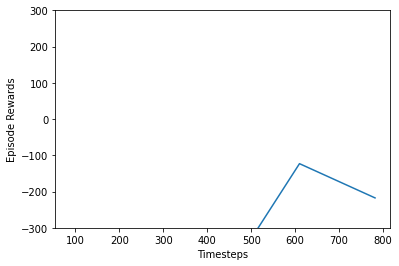

In [ ]:
x, y = ts2xy(load_results(model_path2), 'timesteps')  # Organising the logged results in to a clean format for plotting. timesteps episodes
plt.plot(x,y)
plt.ylim([-300, 300])
plt.xlabel('Timesteps')
plt.ylabel('Episode Rewards')
plt.savefig(model_path2+'reward.png',dpi=600)

##### model for obstacle env

In [ ]:
log_dir3 = drive_path+"obstacle/" #"models"

def objective(trial:optuna.Trial):

  model_log_dir = log_dir3+'dqn_{}'.format(trial.number)+'/'
  os.makedirs(model_log_dir,exist_ok=True) 
  # Create environment
  env = gym.make('LunarLander_obs-v1')
  env = stable_baselines3.common.monitor.Monitor(env, filename= model_log_dir)
  callback = EvalCallback(env,log_path = model_log_dir, deterministic=True) #For evaluating the performance of the agent periodically and logging the results.

  #Trial will suggest a set of hyperparamters from the specified range
  hyperparameters = sample_dqn_params(trial)
  model_dqn = DQN("MlpPolicy", env, **hyperparameters) #Set verbose to 1 to observe training logs. We encourage you to set the verbose to 1.

  # define learning steps
  model3 = model_dqn.learn(total_timesteps=TIMESTEPS, log_interval=10, callback=callback)#100000 
  # save model
  model3.save(model_log_dir +'dqn_{}.zip'.format(trial.number)) 

  x, y = ts2xy(load_results(model_log_dir), 'timesteps') # timesteps
  # clear_output(wait=True)
  #For the given hyperparamters, determine reward
  reward = sum(y)
  return reward

#Create a study object and specify the direction as 'maximize'
#As you want to maximize reward
#Pruner stops not promising iterations
#Use a pruner, else you will get error related to divergence of model
#You can also use Multivariate samplere
#sampler = optuna.samplers.TPESampler(multivarite=True,seed=42)
sampler = optuna.samplers.TPESampler(seed=42)
study3 = optuna.create_study(study_name="dqn_study",direction='maximize',
                            sampler = sampler, pruner=optuna.pruners.HyperbandPruner())

logging_callback = LoggingCallback(threshold=10, patience=30, trial_number=5)
#You can increase the n_trials for a better search space scanning
study3.optimize(objective, n_trials=2, catch=(ValueError,),callbacks=[logging_callback])

[I 2022-07-27 12:37:16,355] A new study created in memory with name: dqn_study
[I 2022-07-27 12:37:19,605] Trial 0 finished with value: -1977.328302 and parameters: {'lr': 0.00064}. Best is trial 0 with value: -1977.328302.
[I 2022-07-27 12:37:22,857] Trial 1 finished with value: -2138.303989 and parameters: {'lr': 0.00065}. Best is trial 0 with value: -1977.328302.


In [ ]:
# use the trial number which has the best result
trial_number = 0
model_path3 = log_dir3+'dqn_'+str(trial_number)+'/'
model3 = DQN.load( model_path3 + 'dqn_'+str(trial_number)+'.zip')

NameError: ignored

In [ ]:
new_env = wrap_env(gym.make("LunarLander_obs-v1"))
observation = new_env.reset()
total_reward = 0

while True:
  new_env.render()
  action, states = model3.predict(observation, deterministic=True)
  observation, reward, done, info = new_env.step(action)
  total_reward += reward
  if done:
    break;

# print(total_reward)
new_env.close()
show_video()

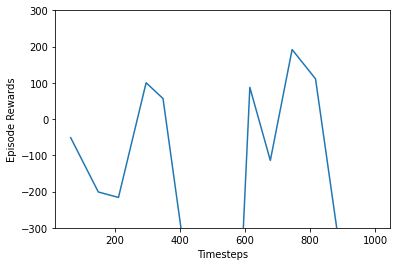

In [ ]:
x, y = ts2xy(load_results(model_path3), 'timesteps')  # Organising the logged results in to a clean format for plotting. timesteps episodes
plt.plot(x,y)
plt.ylim([-300, 300])
plt.xlabel('Timesteps')
plt.ylabel('Episode Rewards')
plt.savefig(model_path3+'reward.png',dpi=600)

## Transder pre-trained models to Obstacle task

### from baseline


In [13]:
model_log_dir = drive_path+"baseline_transferred/" #"models"

In [19]:
os.makedirs(model_log_dir,exist_ok=True) 
# Create environment
env = gym.make('LunarLander_obs-v1')
# env.reset()
env = stable_baselines3.common.monitor.Monitor(env, filename= model_log_dir)
callback = EvalCallback(env,log_path = model_log_dir, deterministic=True) #For evaluating the performance of the agent periodically and logging the results.

# define learning steps
model1.set_env(env, force_reset=True)
print(model1)
model4 = model1.learn(total_timesteps=10, eval_env = env, log_interval=10, callback=callback)#100000 
# save model
model4.save(model_log_dir +'dqn.zip') 

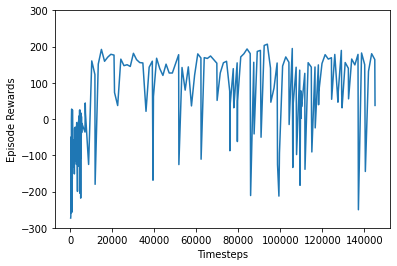

In [ ]:
x, y = ts2xy(load_results(model_log_dir), 'timesteps')  # Organising the logged results in to a clean format for plotting. timesteps episodes
plt.plot(x,y)
plt.ylim([-300, 300])
plt.xlabel('Timesteps')
plt.ylabel('Episode Rewards')
plt.savefig(model_log_dir+'reward.png',dpi=600)

In [ ]:
model4 = DQN.load( model_log_dir + 'dqn.zip')

In [ ]:
new_env = wrap_env(gym.make("LunarLander_obs-v1"))
observation = new_env.reset()
total_reward = 0

while True:
  new_env.render()
  action, states = model4.predict(observation, deterministic=True)
  observation, reward, done, info = new_env.step(action)
  total_reward += reward
  if done:
    break;

# print(total_reward)
new_env.close()
show_video()

### from noisy


In [14]:
model_log_dir = drive_path+"noisy_transferred/" #"models"

In [15]:
os.makedirs(model_log_dir,exist_ok=True) 
# Create environment
env = gym.make('LunarLander_obs-v1')
# env.reset()
env = stable_baselines3.common.monitor.Monitor(env, filename= model_log_dir)
callback = EvalCallback(env,log_path = model_log_dir, deterministic=True) #For evaluating the performance of the agent periodically and logging the results.

# define learning steps
model2.set_env(env, force_reset=True)
model5 = model2.learn(total_timesteps=100000, eval_env = env, log_interval=10, callback=callback)#100000 
# save model
model5.save(model_log_dir +'dqn.zip') 

RuntimeError: ignored

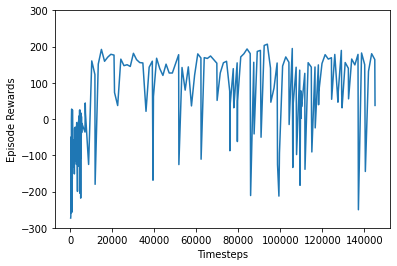

In [ ]:
x, y = ts2xy(load_results(model_log_dir), 'timesteps')  # Organising the logged results in to a clean format for plotting. timesteps episodes
plt.plot(x,y)
plt.ylim([-300, 300])
plt.xlabel('Timesteps')
plt.ylabel('Episode Rewards')
plt.savefig(model_log_dir+'reward.png',dpi=600)

In [ ]:
model4 = DQN.load( model_log_dir + 'dqn.zip')

In [ ]:
new_env = wrap_env(gym.make("LunarLander_obs-v1"))
observation = new_env.reset()
total_reward = 0

while True:
  new_env.render()
  action, states = model4.predict(observation, deterministic=True)
  observation, reward, done, info = new_env.step(action)
  total_reward += reward
  if done:
    break;

# print(total_reward)
new_env.close()
show_video()

---
# References

1. Stable Baselines Framework: https://stable-baselines3.readthedocs.io/en/master/guide/examples.html

2. Lunar Lander Environment: https://gym.openai.com/envs/LunarLander-v2/

3. OpenAI gym environments: https://gym.openai.com/docs/

4. A good reference for introduction to RL: http://incompleteideas.net/book/the-book-2nd.html
